# LSTM

In [1]:
import torch
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True,
                  pad_first=True)
LABEL = data.LabelField(dtype = torch.float)

In [2]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [3]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [4]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [5]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

## Build the Model

In [6]:
import torch.nn as nn

import numpy as np

class LSTM_uni(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        self.LSTM = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, bidirectional=False)

        self.FL = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, text, text_lengths):
        
        embedded = self.embedding(text)
        
        output, (hidden, cell)= self.LSTM(embedded)

        return self.FL(hidden.squeeze(0)) 

In [7]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model_LSTM_uni = LSTM_uni(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
print(f'The model has {count_parameters(model_LSTM_uni):,} trainable parameters')

for p in model_LSTM_uni.parameters():
  print(type(p), p.size())

The model has 2,867,049 trainable parameters
<class 'torch.nn.parameter.Parameter'> torch.Size([25002, 100])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024, 100])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024, 256])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([1, 256])
<class 'torch.nn.parameter.Parameter'> torch.Size([1])


## Train the Model

In [8]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [9]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [10]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        text, text_lengths = batch.text

        predictions = model(text, text_lengths).squeeze(1)

        loss = criterion(predictions, batch.label)

        acc = binary_accuracy(predictions, batch.label)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [11]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:
            text, text_lengths = batch.text

            predictions = model(text, text_lengths).squeeze(1)

            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [12]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 0.002 | Train Acc: 99.92%
	 Val. Loss: 0.950 |  Val. Acc: 86.63%
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.001 | Train Acc: 99.97%
	 Val. Loss: 0.866 |  Val. Acc: 86.51%
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.006 | Train Acc: 99.83%
	 Val. Loss: 0.753 |  Val. Acc: 85.17%
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.006 | Train Acc: 99.85%
	 Val. Loss: 0.776 |  Val. Acc: 86.92%
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 0.002 | Train Acc: 99.93%
	 Val. Loss: 0.836 |  Val. Acc: 87.21%
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 0.926 |  Val. Acc: 87.14%
Epoch: 07 | Epoch Time: 0m 8s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 0.966 |  Val. Acc: 87.25%
Epoch: 08 | Epoch Time: 0m 8s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 0.999 |  Val. Acc: 87.20%
Epoch: 09 | Epoch Time: 0m 8s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.026 |  Val. Acc: 87.27%
Epoch: 10 | Epoch Time: 

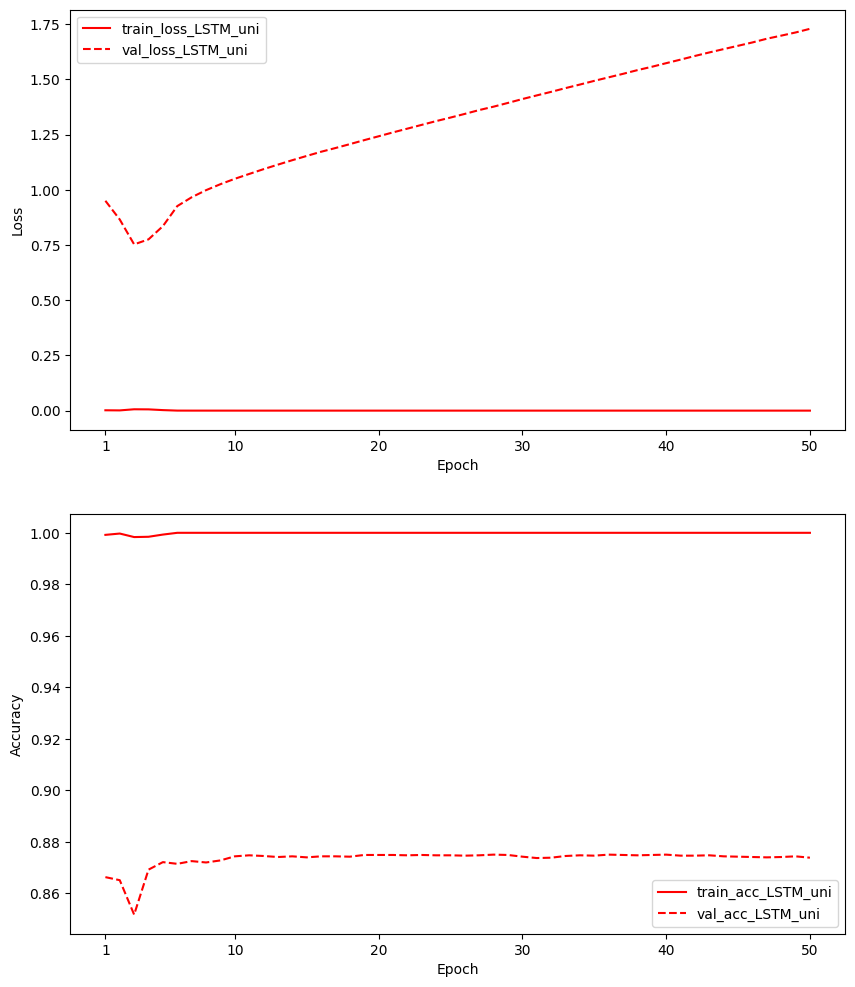

In [15]:
import matplotlib.pyplot as plt

optimizer_Adam = optim.Adam(model_LSTM_uni.parameters(), lr=1e-3)
model_LSTM_uni = model_LSTM_uni.to(device)

N_EPOCHS = 50

train_loss_LSTM_uni = []
train_acc_LSTM_uni = []
val_loss_LSTM_uni = []
val_acc_LSTM_uni = []
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_LSTM_uni, train_iterator, optimizer_Adam, criterion)
    valid_loss, valid_acc = evaluate(model_LSTM_uni, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_LSTM_uni.state_dict(), 'model_LSTM_uni.pt')
    
    train_loss_LSTM_uni.append(train_loss)
    train_acc_LSTM_uni.append(train_acc)
    val_loss_LSTM_uni.append(valid_loss)
    val_acc_LSTM_uni.append(valid_acc)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,12))
ax1.plot(train_loss_LSTM_uni, 'r-', label='train_loss_LSTM_uni')
ax1.plot(val_loss_LSTM_uni, 'r--', label='val_loss_LSTM_uni')
ax2.plot(train_acc_LSTM_uni, 'r-', label='train_acc_LSTM_uni')
ax2.plot(val_acc_LSTM_uni, 'r--', label='val_acc_LSTM_uni')

ax1.set_xticks([0,9,19,29,39,49], labels=[1,10,20,30,40,50])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.set_xticks([0,9,19,29,39,49], labels=[1,10,20,30,40,50])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()


# 
model_LSTM_uni.load_state_dict(torch.load('model_LSTM_uni.pt'))

test_loss_LSTM_uni, test_acc_LSTM_uni = evaluate(model_LSTM_uni, test_iterator, criterion)

print(f'Test Loss: {test_loss_LSTM_uni:.3f} | Test Acc: {test_acc_LSTM_uni*100:.2f}%')

# Bi-LSTM

In [16]:
class LSTM_bi(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        self.LSTM = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, bidirectional=True)

        self.FL = nn.Linear(hidden_dim*2, output_dim)
        
        
    def forward(self, text, text_lengths):
        
        embedded = self.embedding(text)
        
        output, (hidden, cell)= self.LSTM(embedded)

        hidden = torch.cat((hidden[0,:,:], hidden[1,:,:]), dim=1)

        return self.FL(hidden) 

In [17]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model_LSTM_bi = LSTM_bi(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
print(f'The model has {count_parameters(model_LSTM_bi):,} trainable parameters')

The model has 3,233,897 trainable parameters


Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.366 | Train Acc: 84.31%
	 Val. Loss: 0.434 |  Val. Acc: 81.06%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.309 | Train Acc: 87.20%
	 Val. Loss: 0.401 |  Val. Acc: 84.30%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.235 | Train Acc: 90.80%
	 Val. Loss: 0.406 |  Val. Acc: 83.26%
Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.175 | Train Acc: 93.43%
	 Val. Loss: 0.445 |  Val. Acc: 84.45%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.146 | Train Acc: 94.60%
	 Val. Loss: 0.447 |  Val. Acc: 83.96%
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.088 | Train Acc: 97.07%
	 Val. Loss: 0.464 |  Val. Acc: 85.43%
Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 0.052 | Train Acc: 98.50%
	 Val. Loss: 0.545 |  Val. Acc: 84.31%
Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 0.046 | Train Acc: 98.49%
	 Val. Loss: 0.579 |  Val. Acc: 84.39%
Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 0.020 | Train Acc: 99.46%
	 Val. Loss: 0.668 |  Val. Acc: 85.45%
Epoch: 10 | Epoch T

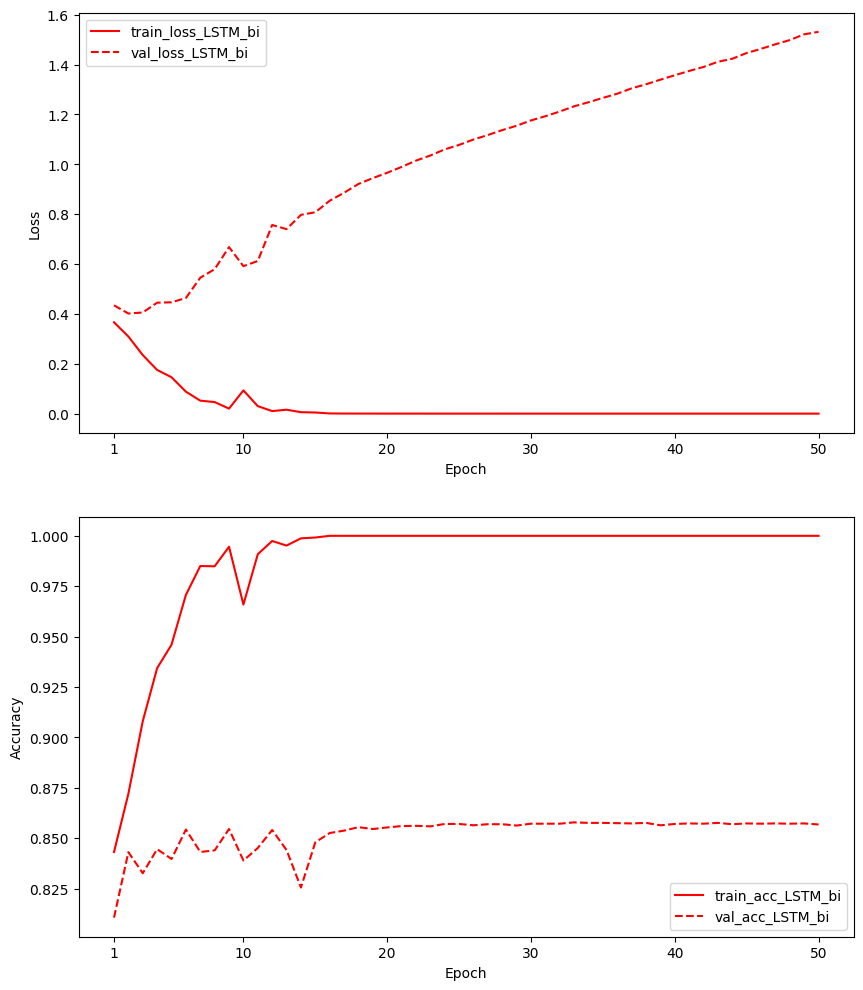

In [19]:
optimizer_Adam = optim.Adam(model_LSTM_bi.parameters(), lr=1e-3)
model_LSTM_bi = model_LSTM_bi.to(device)

N_EPOCHS = 50

train_loss_LSTM_bi = []
train_acc_LSTM_bi = []
val_loss_LSTM_bi = []
val_acc_LSTM_bi = []
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_LSTM_bi, train_iterator, optimizer_Adam, criterion)
    valid_loss, valid_acc = evaluate(model_LSTM_bi, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_LSTM_bi.state_dict(), 'model_LSTM_bi.pt')
    
    train_loss_LSTM_bi.append(train_loss)
    train_acc_LSTM_bi.append(train_acc)
    val_loss_LSTM_bi.append(valid_loss)
    val_acc_LSTM_bi.append(valid_acc)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,12))
ax1.plot(train_loss_LSTM_bi, 'r-', label='train_loss_LSTM_bi')
ax1.plot(val_loss_LSTM_bi, 'r--', label='val_loss_LSTM_bi')
ax2.plot(train_acc_LSTM_bi, 'r-', label='train_acc_LSTM_bi')
ax2.plot(val_acc_LSTM_bi, 'r--', label='val_acc_LSTM_bi')

ax1.set_xticks([0,9,19,29,39,49], labels=[1,10,20,30,40,50])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.set_xticks([0,9,19,29,39,49], labels=[1,10,20,30,40,50])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()


# 
model_LSTM_bi.load_state_dict(torch.load('model_LSTM_bi.pt'))

test_loss_LSTM_bi, test_acc_LSTM_bi = evaluate(model_LSTM_bi, test_iterator, criterion)

print(f'Test Loss: {test_loss_LSTM_bi:.3f} | Test Acc: {test_acc_LSTM_bi*100:.2f}%')